# Follow-Up: Same Experiments, Different Data

**Note**: This notebook is a work in progress. 

A significant flaw in our previous experiments was that our feature selection was not realistic. To predict success of a terrorist attack, we ought to really restrict ourselves to things that we might know in advance - not factors such as number killed or wounded. 

The "Casualties and Consequences" section of our dataset [codebook](http://www.start-dev.umd.edu/gtd/downloads/Codebook.pdf) is a good standard for variables in the data that cannot be predicted in advance. 

In this notebook, I'll select a different subset of the features in the data to figure out if the same experiments we ran are still useful.

## Data Prep

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Modifying functions from preprocess
from preprocess_functions import load_raw_data

unused_cols = ['approxdate', 'resolution', 'eventid', 'extended', 'resolution', 
                'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 
                'alternative', 'alternative_txt', 'multiple', 'suicide', 'attacktype1', 'attacktype2', 
                'attacktype3', 'corp1', 'target1', 'targtype2', 'targsubtype2', 'corp2', 
                'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 
                'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt', 'gsubname', 
                'gname2', 'gsubname2', 'gname3', 'gsubname3', 'guncertain1', 'guncertain2', 
                'guncertain3', 'guncertain3', 'individual', 'nperps', 'nperpcap', 'claimed', 
                'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 
                'claimmode3', 'claimmode3_txt', 'compclaim', 'weaptype2', 'weaptype2_txt', 'weapsubtype2', 
                'weapsubtype2_txt', 'weaptype3', 'weaptype3_txt', 'weapsubtype3', 'weapsubtype3_txt', 
                'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt', 'weapdetail', 'ishostkid', 
                'nhostkid', 'nhostkidus', 'nhours', 'ndays', 'divert', 'kidhijcountry', 'ransomamtus', 
                'ransompaid', 'ransompaidus', 'ransomnote', 'hostkidoutcome', 'hostkidoutcome_txt', 
                'nreleased', 'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG', 
                'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related', 'nkill', 'nkillus', 'nkillter', 'nwound', 
                'nwoundus', 'nwoundte', 'property','propextent', 'propextent_txt', 'propvalue', 'propcomment', 
                'ransom', 'ransomamt']

def load_data_relevant_cols(): 
    '''
    Output: A pandas dataframe which contains all data points, 
    but only the columns we actually use.
    '''
    raw = load_raw_data()
    return raw.drop(unused_cols, axis=1)

def get_dummies(df, columns):
    '''
    Output: A Pandas dataframe which contains the one-hot-encoded versions 
    of the categorical columns specified in 'columns', on the data frame df
    '''
    output = pd.get_dummies(df[columns[0]], prefix=columns[0])
    for column in columns[1:]:
        output = output.join(pd.get_dummies(df[column], prefix=column))
    return output

In [3]:
raw = load_data_relevant_cols()

/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
raw.columns.values

array(['iyear', 'imonth', 'iday', 'country', 'country_txt', 'region',
       'region_txt', 'provstate', 'city', 'latitude', 'longitude',
       'specificity', 'success', 'attacktype1_txt', 'attacktype2_txt',
       'attacktype3_txt', 'targtype1', 'targtype1_txt', 'targsubtype1',
       'targsubtype1_txt', 'natlty1', 'natlty1_txt', 'targtype2_txt',
       'targsubtype2_txt', 'gname', 'motive', 'weaptype1', 'weaptype1_txt',
       'weapsubtype1', 'weapsubtype1_txt'], dtype=object)

Now that we have our raw data, we'll turn it into numerical values with a one hot encoding. But there's a problem - our database has over 3,000 terrorist groups, so the vectors would be incredibly large if we one-hot encoded based on group name. To simplify this, we'll label every group not in the top group as "other" so the dimension is around 30 instead of 3,000. 

In [5]:
import shelve 

#load up intermediate results from counter_terrorism_nb1
with shelve.open('intermediate_results/vars1') as db:
    top_terror_groups = db['top_terror_groups']

In [6]:
top_group_names = [group_tuple[0] for group_tuple in top_terror_groups]

In [7]:
top_group_names.append('Unknown')

In [8]:
replace_name = lambda group_name: group_name if group_name in top_group_names else 'Other'

In [9]:
raw['gname'] = raw['gname'].apply(replace_name)

In [10]:
len(raw['gname'][raw['gname'] == 'Other'])/len(raw)

0.22939829762254182

Looks like we've only replaced about 23% of the names, so this isn't tossing out too much information. We're losing some information, but for a quick computational pass it's not terrible.

Finally, let's one-hot encode categorial features.

In [12]:
categorical_features = ['country_txt', 'region_txt', 'attacktype1_txt', 'attacktype2_txt',
                       'attacktype3_txt', 'targtype1_txt', 'targsubtype1_txt', 'natlty1_txt', 'targtype2_txt',
                       'targsubtype2_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'gname']

numerical_features = ['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'success']

one_hot_X = get_dummies(raw, categorical_features)
numeric_data = raw[numerical_features]
all_data = one_hot_X.join(numeric_data).dropna()

In [13]:
all_data.head()

,country_txt_Afghanistan,country_txt_Albania,country_txt_Algeria,country_txt_Andorra,country_txt_Angola,country_txt_Antigua and Barbuda,country_txt_Argentina,country_txt_Armenia,country_txt_Australia,country_txt_Austria,...,gname_Taliban,gname_Tehrik-i-Taliban Pakistan (TTP),gname_Tupac Amaru Revolutionary Movement (MRTA),gname_Unknown,iyear,imonth,iday,latitude,longitude,success
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1970.0,7.0,2.0,18.456792,-69.951164,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1970.0,0.0,0.0,19.432608,-99.133207,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1970.0,1.0,0.0,15.478598,120.599741,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1970.0,1.0,0.0,37.983773,23.728157,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1970.0,1.0,0.0,33.580412,130.396361,1.0


All right! Finally, let's do a train-test split and then train some models.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
np.random.seed(159)

In [15]:
y_labels = all_data['success']
x_data = all_data.drop(columns=['success'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.1, random_state=42)

## Random Forest

Let's train the best random forest from last time and see what's up.

In [17]:
init_forest = RandomForestClassifier(n_estimators=7, criterion='gini', max_features=None, 
                                     random_state=159, max_depth = 10)
init_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=1,
            oob_score=False, random_state=159, verbose=0, warm_start=False)

In [18]:
y_pred_int = init_forest.predict(X_test)

In [19]:
accuracy_score(y_test, y_pred_int)

0.91324283559577679

Nice! Looks like the random forest was still able to get 91% without access to the `nkill` feature. Let's see what features it thinks are important.

In [20]:
feature_weights = init_forest.feature_importances_
feature_names = X_train.columns.values

'''
Construct a dictionary whose keys are feature names, 
and values are the feature's importance.
'''
feature_weight_dict = {}
for i in range(len(feature_names)): 
    feature_weight_dict[feature_names[i]] = feature_weights[i]
    
#Sort features by importance
features_by_importance = sorted(feature_weight_dict, key=feature_weight_dict.get, reverse=True)

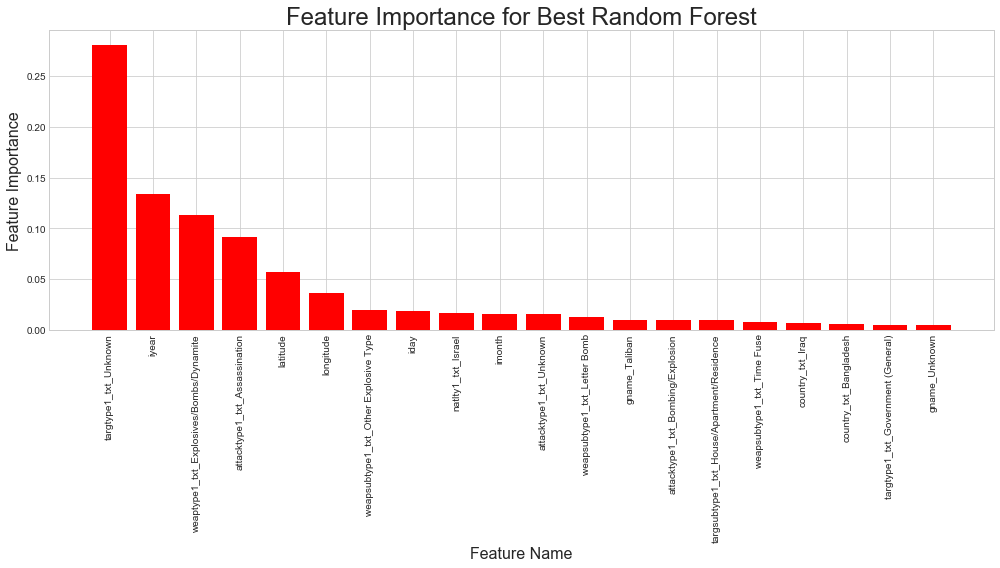

In [21]:
#plot the features
from seaborn import set_style
set_style('whitegrid')
# sns.set_sytle('whitegrid')
num_features = 20
plt.figure(figsize=(14, 8))
plt.title('Feature Importance for Best Random Forest', fontsize=24)
feature_importances = [feature_weight_dict[key] for key in features_by_importance[:num_features]]
plt.bar(range(num_features), feature_importances,
       color='red', align='center')
plt.xticks(range(num_features), features_by_importance[:num_features])
plt.xticks(rotation=90)
plt.xlabel('Feature Name', fontsize=16)
plt.ylabel('Feature Importance', fontsize=16)
plt.tight_layout()
plt.savefig('figures/random_forest_feature_importance.png')
plt.show();

## Exploring Feature Importance

Let's look at how the trained model corresponds to different features as a predictor of success of the attack. 

### Year